# ***MAKEMORE: RNN ARCHITECTURE (WAVE NET)***

### Importing Libs

In [3]:
import torch
torch.manual_seed(42); # seed rng for reproducibility
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

### Reading list of names (all lowered already)

In [4]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Building vocab of chars and mapping into integers

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset

In [6]:
block_size = 3
X, Y = [], []
for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

### Train Test Validation splits

In [7]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

# 80% train, 10% validation, 10% test
train = words[:int(.8 * len(words))]
valid = words[int(.8 * len(words)):int(.9 * len(words))]
test = words[int(.9 * len(words)):]

X_train, Y_train = build_dataset(train)
X_valid, Y_valid = build_dataset(valid)
X_test, Y_test = build_dataset(test)

In [8]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

### MLP
Adjusting the intialization weights so that the gaussians keep std =~ 1. More details on <a href="https://pytorch.org/docs/stable/nn.init.html"> this link </a>



In [9]:
g = torch.Generator().manual_seed(42)
# Embedding matrix
n_emb = 10
n_hidden = 200
C = torch.randn((27, n_emb), generator=g)
# MLP weights and biases
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3)/((n_emb*block_size + n_hidden)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]
for p in params:
    p.requires_grad = True

### Check how gaussians behave through forward pass

tensor(0.0025) tensor(1.0073)
tensor(-0.0003) tensor(1.0160)


(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 4.0000e+00, 6.0000e+00, 7.0000e+00,
        1.1000e+01, 9.0000e+00, 1.2000e+01, 1.5000e+01, 2.7000e+01,
        3.0000e+01, 3.9000e+01, 5.5000e+01, 9.3000e+01, 9.3000e+01,
        1.4700e+02, 1.9700e+02, 2.6800e+02, 3.3700e+02, 4.5400e+02,
        5.6600e+02, 7.6500e+02, 1.0220e+03, 1.2560e+03, 1.5670e+03,
        2.1670e+03, 2.7180e+03, 3.3750e+03, 4.2610e+03, 5.3030e+03,
        6.6710e+03, 8.3170e+03, 1.0234e+04, 1.2447e+04, 1.5206e+04,
        1.8206e+04, 2.1639e+04, 2.5480e+04, 2.9273e+04, 3.3322e+04,
        3.7694e+04, 4.1598e+04, 4.6089e+04, 4.9667e+04, 5.1997e+04,
        5.3559e+04, 5.3802e+04, 5.2966e+04, 5.0525e+04, 4.8079e+04,
        4.4138e+04, 3.9769e+04, 3.6021e+04, 3.1491e+04, 2.7322e+04,
        2.3439e+04, 1.9828e+04, 1.6809e+04, 1.3816e+04, 1.1214e+04,
        9.3330e+03, 7.4190e+03, 6.0770e+03, 4.7740e+03, 3.7730e+03,
        2.9550e+03, 2.3550e+03, 1.8970e+03, 1.43

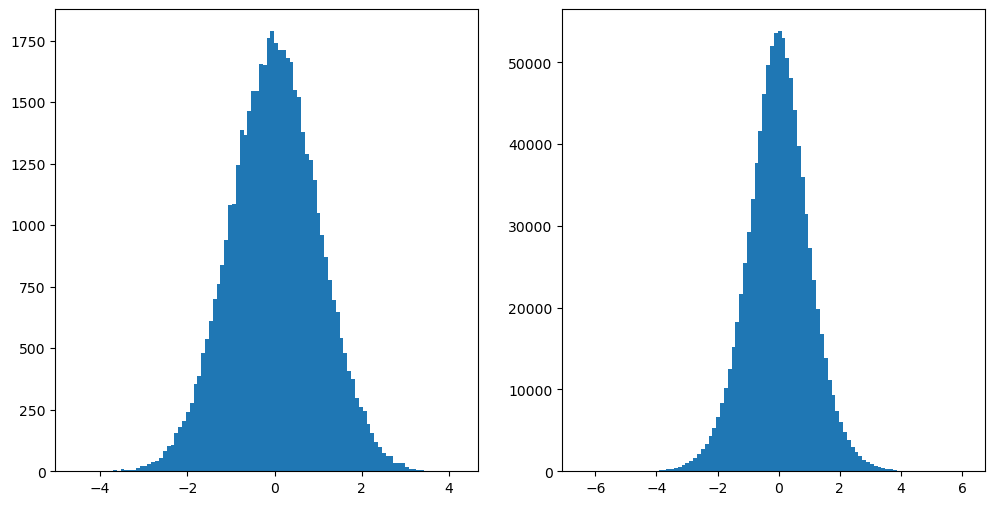

In [10]:
x = torch.randn(5000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(x.view(-1), bins=100)
plt.subplot(122)
plt.hist(y.view(-1), bins=100)

## Making modules for each layer type

In [11]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [12]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # PARAMS
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # NOT PARAMS (no backprop here)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [13]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [14]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

In [15]:
class Flatten:
      
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

In [16]:
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

In [17]:
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # Return all the parameters from all layers
    return [p for layer in self.layers for p in layer.parameters()]


### New model using modules

In [18]:
n_embd = 24
n_hidden = 128
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
  

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


### Training the MLP

In [19]:
[i for j in range(3) for i in range(6,11)]

[6, 7, 8, 9, 10, 6, 7, 8, 9, 10, 6, 7, 8, 9, 10]

In [20]:
lossi = []
lri = []
stepi = []
losses = []
n_steps = 100000
batch_size = 32
for i in range(n_steps):
    # Minibatch Creation
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # Forward
    emb = C[Xb] #Take the embeddings
    embcat = emb.view(emb.shape[0], -1) #concatenate the embeddings (flatten)
    h_preact = (embcat @ W1) + b1 # hidden pre-activation
    bn_mean_i = h_preact.mean(0, keepdims=True)
    bn_std_i = h_preact.std(0, keepdims=True)
    h_preact = (h_preact - bn_mean_i) / bn_std_i # batch normalization
    h_preact = (h_preact * bn_gain) + bn_bias # scale and shift
    
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    
    h = torch.tanh(h_preact) # hidden activation
    logits = (h @ W2) + b2 #  output layer (numerical values)
    # Neg Log lokelihood
    loss = F.cross_entropy(logits, Yb)
    
    #Backward
    for p in params:
        p.grad = None
    loss.backward() 
    
    # update params
    lr = 0.1 if i < int(.5*n_steps) else 0.01
    # lr = lri[i]
    for p in params:
        p.data += -p.grad * lr
    # lossi.append(loss.item())
    # lri.append(lr)
    
    # track metrics
    if i%10000 == 0:
        print(f'{i:7d}/{n_steps:7d} Loss: {loss.item():.4f}')
    stepi.append(i)
    losses.append(loss.log10().item())
    #break

      0/ 100000 Loss: 3.2905
  10000/ 100000 Loss: 2.3939
  20000/ 100000 Loss: 2.0469
  30000/ 100000 Loss: 2.0583
  40000/ 100000 Loss: 2.2502
  50000/ 100000 Loss: 2.2099
  60000/ 100000 Loss: 1.9231
  70000/ 100000 Loss: 1.9300
  80000/ 100000 Loss: 1.8470
  90000/ 100000 Loss: 1.9804


## Mean and std at the end

In [25]:
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = (embcat @ W1) + b1
    # mean and std of the pre-activation
    bn_mean = h_preact.mean(0, keepdims=True)
    bn_std = h_preact.std(0, keepdims=True)

In [26]:
bn_mean - bn_mean_running, bn_std - bn_std_running

(tensor([[-2.8719e-03, -1.3858e-02,  6.8337e-03,  2.5829e-02, -5.9835e-03,
          -9.1991e-03,  2.6587e-03, -1.2255e-03,  1.2036e-02,  3.1973e-03,
           1.9819e-03,  8.5813e-04,  1.9147e-02,  3.0696e-03, -4.0165e-03,
           1.1766e-02,  7.7556e-03, -1.1358e-02,  1.0453e-03,  1.0978e-03,
          -3.4360e-03,  7.7195e-03,  2.0364e-02,  2.2324e-02, -3.5158e-03,
           8.9281e-03, -6.5058e-04,  5.4198e-03,  4.0224e-03,  6.2442e-03,
          -9.6824e-03,  8.4774e-03, -1.4537e-02, -1.5694e-03, -2.6768e-03,
          -1.5600e-03, -1.7931e-02, -3.1544e-03, -4.3057e-05, -1.2182e-03,
           9.5417e-03,  9.1441e-03,  1.2826e-02,  3.7956e-03,  5.0372e-03,
           8.9660e-03, -7.2476e-03,  2.2626e-03,  1.7312e-02,  8.5283e-03,
          -2.3287e-03,  4.3098e-03, -2.5624e-02,  2.3174e-03, -1.5878e-02,
          -3.6122e-03, -3.1115e-03, -1.2482e-02,  7.9904e-03,  9.3264e-03,
          -2.8681e-03,  6.9872e-03,  1.7952e-03,  7.8504e-03,  2.4672e-03,
          -7.8224e-03, -5

## Check Losses

In [27]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'valid': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = (embcat @ W1) + b1
    h_preact = (h_preact - bn_mean_running) / bn_std_running
    h_preact = (h_preact * bn_gain) + bn_bias
    h = torch.tanh(h_preact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('valid')
split_loss('test') 

train 2.081333875656128
valid 2.1188321113586426
test 2.120009422302246


## Visualize Losses

Text(0, 0.5, 'Loss')

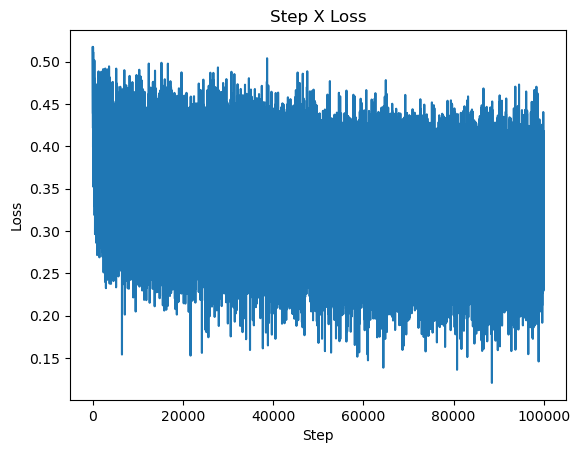

In [28]:
plt.plot(stepi, losses)
plt.title("Step X Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

## Sampling from the model

In [29]:
for _ in range(20):
    out = []
    context = [0]*block_size
    with torch.no_grad():
        while True:
            emb = C[torch.tensor([context])]
            h_preact = emb.view(1, -1) @ W1 + b1
            h_preact = (h_preact - bn_mean) / bn_std
            h_preact = h_preact * bn_gain + bn_bias
            h = torch.tanh(h_preact)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, 1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0: break
        print(''.join([itos[i] for i in out]))

adier.
delys.
werio.
syr.
cavee.
firton.
holeighand.
tarie.
gadele.
rwin.
saulya.
kawdina.
crai.
eishana.
ani.
alywe.
nahnaharie.
day.
deklalonason.
bridy.
